In [2]:
# type: ignore , so it doesnt report missing import
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable info and warning messages
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from keras import optimizers

import statistics
%matplotlib inline
print(tf.__version__)

2.10.1


Number of images: 1208
Mean: 100.33940397350993
Geometric mean: 90.4980028928942
Median: 83.0
Min: 49
Max: 514


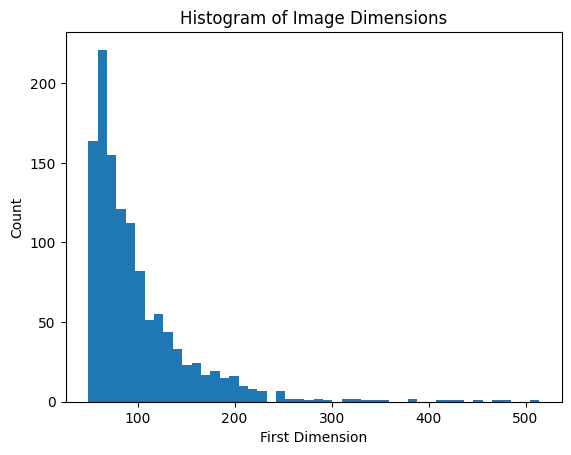

In [3]:
dataset="../mldataset/cropped"
dirs = [
    os.path.join(dataset, "ConfirmedFiles"),
    os.path.join(dataset, "RejectedFiles")
]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        imgs = os.path.join(i, j, "images")
        if not os.path.exists(imgs):
            continue
        for img in os.listdir(imgs):

            img = os.path.join(imgs, img)

            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Mean:", np.mean(dimensions))
print("Geometric mean:", statistics.geometric_mean(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=32,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(83, 83),
)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1208 files belonging to 2 classes.
Using 967 files for training.
Using 241 files for validation.


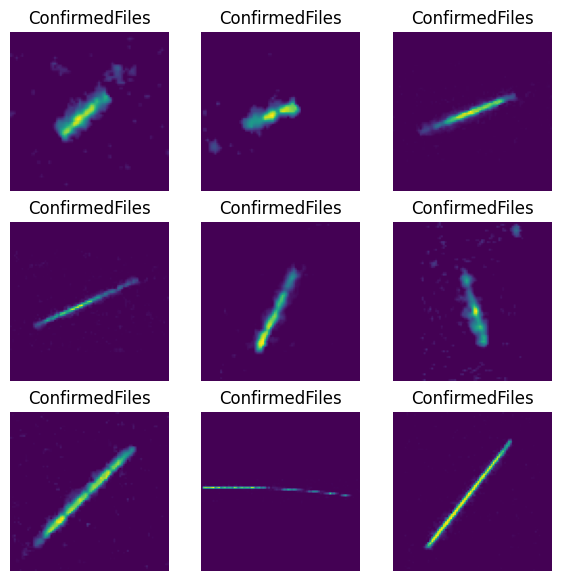

In [5]:
inputs = keras.Input(shape=(83, 83, 1))
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")

        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

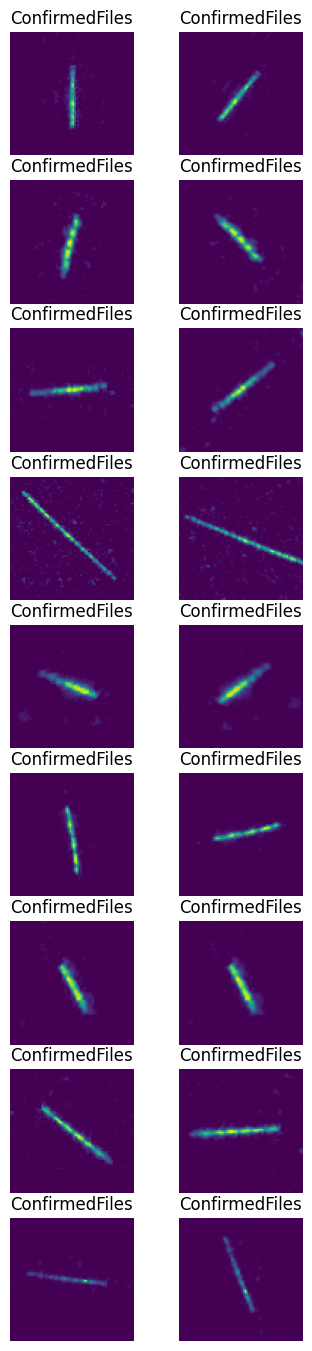

In [18]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)
plt.figure(figsize=(4, 17))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(9, 2, i*2 + 1)
        img = images[i]
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

      
        ax = plt.subplot(9, 2, i*2 + 2)
        img=data_augmentation(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        #print(labels[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off") 

In [7]:

model = models.Sequential()
model.add(layers.Conv2D(8, (5, 5), activation="relu", input_shape=(83,83,1)))
model.add(layers.MaxPooling2D((5,5)))
#model.add(layers.Conv2D(64, (3,3), activation="relu"))
#model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(64, (3,3), activation="relu"))
#model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 79, 79, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1800)              0         
                                                                 
 dense (Dense)               (None, 16)                28816     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,041
Trainable params: 29,041
Non-trainable params: 0
__________________________________________________

In [8]:

model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(), metrics=["acc"])

In [9]:
history = model.fit(
train_ds,
# steps_per_epoch=36,
epochs=10,
validation_data=val_ds)

Epoch 1/10
31/31 [==============================] - 2s 10ms/step - loss: 0.3151 - acc: 0.9131 - val_loss: 0.1279 - val_acc: 0.9461
Epoch 2/10
31/31 [==============================] - 0s 4ms/step - loss: 0.0935 - acc: 0.9731 - val_loss: 0.0887 - val_acc: 0.9668
Epoch 3/10
31/31 [==============================] - 0s 4ms/step - loss: 0.0720 - acc: 0.9772 - val_loss: 0.0803 - val_acc: 0.9710
Epoch 4/10
31/31 [==============================] - 0s 4ms/step - loss: 0.0570 - acc: 0.9793 - val_loss: 0.1004 - val_acc: 0.9668
Epoch 5/10
31/31 [==============================] - 0s 4ms/step - loss: 0.0452 - acc: 0.9855 - val_loss: 0.0929 - val_acc: 0.9668
Epoch 6/10
31/31 [==============================] - 0s 4ms/step - loss: 0.0399 - acc: 0.9897 - val_loss: 0.1194 - val_acc: 0.9668
Epoch 7/10
31/31 [==============================] - 0s 4ms/step - loss: 0.0322 - acc: 0.9866 - val_loss: 0.1112 - val_acc: 0.9668
Epoch 8/10
31/31 [==============================] - 0s 4ms/step - loss: 0.0272 - acc: 0.9